SanFrancisco Crime Analysis from Summer 2014 Data

In [53]:
%matplotlib inline
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
from statsmodels.graphics.mosaicplot import mosaic

matplotlib.style.use('ggplot')

From a casual look at data we can see that there crimes are divided into several "types", the first question I wanted to answer was what is the most common crime in this period. The plot below shows that "Larceny/Theft" stands out as significantly higher than the next closest crime type.

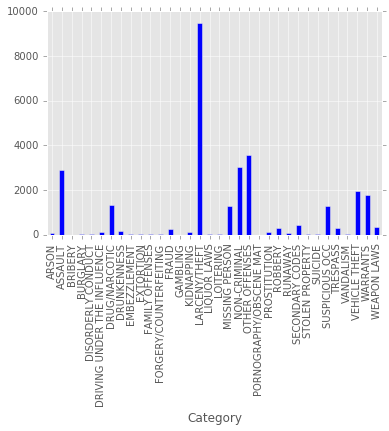

In [54]:
df = pd.read_csv("sanfrancisco_incidents_summer_2014.csv")
df.groupby('Category').size().plot(kind='bar');

Crime in Unitied States is very neighborhood centric, so I wanted to check how the number of criminal instances vary based on the San Francison Neighborhoods tracked in the data. Data shows that there is a clear area which significantly more crime instances ("Southern") than others. Richmond and Park neighborhoods had the least instances.

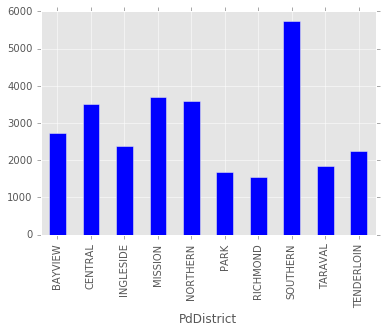

In [55]:
df.groupby('PdDistrict').size().plot(kind='bar');

Another view into the data can be to see correlation between a day of week and time of day with number of crimes. First a look at how the crime data varies depending on the day of the week below shows that there is no strong correlation between crime and day of the week.

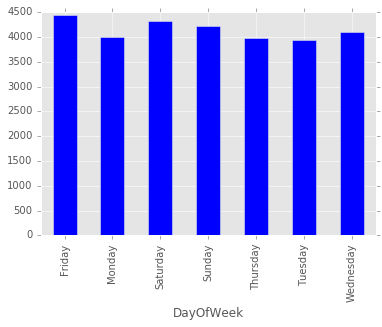

In [56]:
df.groupby('DayOfWeek').size().plot(kind='bar');

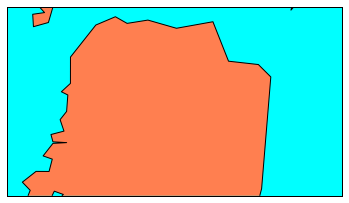

In [57]:
map = Basemap(projection='merc', lat_0 = 37, lon_0 = -122,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-122.346565, llcrnrlat=37.721389,
    urcrnrlon= -122.561093, urcrnrlat=37.816924)

map.drawcoastlines();
map.fillcontinents(color = 'coral');
map.drawmapboundary(fill_color='aqua');



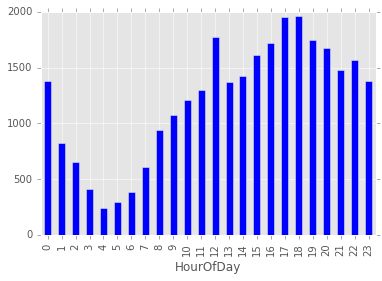

In [58]:
def get_hour(row):
    return int(row['Time'].split(":")[0])

df['HourOfDay'] = df.apply(lambda row: get_hour(row), axis=1)
df.groupby('HourOfDay').size().plot(kind='bar');

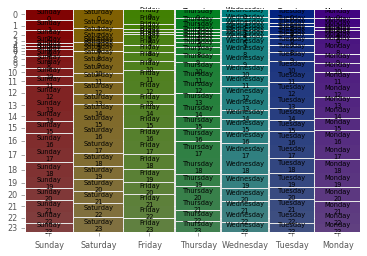

In [60]:
plt.rcParams['font.size'] = 8.0

mosaic(df, ['DayOfWeek', 'HourOfDay']);

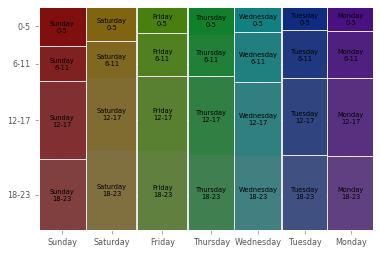

In [64]:
qtr_hr = {0: '0-5', 1:'6-11',2:'12-17',3:'18-23'}
def get_quarter_hour(row):
    hr = int(row['Time'].split(":")[0])
    return qtr_hr[hr / 6]

df['QtrHr'] = df.apply(lambda row: get_quarter_hour(row), axis=1)
mosaic(df, ['DayOfWeek', 'QtrHr']);

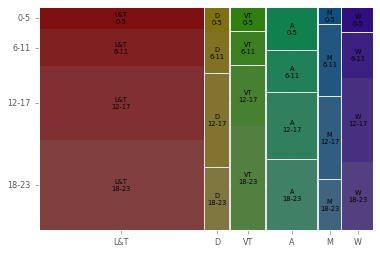

In [75]:
important_category = {'LARCENY/THEFT':'L&T', 'VEHICLE THEFT':'VT', 
                      'WARRANTS':'W', 'MISSING PERSON':'M', 'ASSAULT':'A',
                      'DRUG/NARCOTIC': 'D'}

def get_imp_category(row):
    if row['Category'] in important_category.keys():
        return important_category[row['Category']]
    else:
        return 'O'

df2 = df [ df.Category.isin( ['LARCENY/THEFT', 'VEHICLE THEFT','WARRANTS',
                              'MISSING PERSON','ASSAULT','DRUG/NARCOTIC'] ) ].copy()

df2['ImpCategory'] = df2.apply(lambda row: get_imp_category(row), axis=1)    
    
mosaic(df2, ['ImpCategory', 'QtrHr']);
df2 = None